# Initial Steps

In [1]:
# Install necessary libraries if not already installed
!pip install xgboost lightgbm scikit-learn pandas numpy matplotlib seaborn --quiet
# Install imbalanced-learn if not already installed
!pip install imbalanced-learn --quiet

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE

In [3]:
# Load dataset
df = pd.read_csv("/content/cleaned_train.csv")

In [4]:
# Sample 20% of the dataset
sample_fraction = 0.2  # Use 20% of the dataset
df = df.sample(frac=sample_fraction, random_state=42)

In [5]:
# Define features and target
X = df.drop(columns=["cluster_category", "outlet_city", "Customer_ID"])
y = df["cluster_category"]

In [6]:
# Split the sampled data into training and testing sets
X_train_sample, X_test_sample, y_train_sample, y_test_sample = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [7]:
# Original class distribution
print("Original class distribution:\n", y_train_sample.value_counts())

# Adjust SMOTE sampling strategy to avoid exceeding original class sizes
# Ensure no class gets more samples than its original count
smote = SMOTE(sampling_strategy='auto', random_state=42)  # 'auto' resampling strategy balances the classes
X_train_sample, y_train_sample = smote.fit_resample(X_train_sample, y_train_sample)

# Print new class distribution after SMOTE
print("\nBalanced class distribution (after SMOTE):\n", pd.Series(y_train_sample).value_counts())


Original class distribution:
 cluster_category
1.0    27270
6.0    27058
2.0    24904
4.0    22796
3.0     7684
5.0     4306
Name: count, dtype: int64

Balanced class distribution (after SMOTE):
 cluster_category
6.0    27270
5.0    27270
1.0    27270
4.0    27270
2.0    27270
3.0    27270
Name: count, dtype: int64


# EBM (Train Accuracy: 0.8844, Test Accuracy:  0.8809)

In [8]:
!pip install interpret

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 33.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 81.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 92.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 94.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 93.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 778.9/778.9 kB 38.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 60.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.3/144.3 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━

In [9]:
# Ensure consistent target label types (e.g., all int)
y_train_sample = y_train_sample.astype(int)
y_test_sample = y_test_sample.astype(int)

In [10]:
from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
# Train Explainable Boosting Machine with optimized params
from interpret.glassbox import ExplainableBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

ebm_model = ExplainableBoostingClassifier(random_state=42)

In [12]:
# Hyperparameter grid
param_grid = {
    "max_rounds": [30, 50],         # Lower rounds (less training complexity)
    "max_leaves": [5, 10],          # Smaller trees to avoid overfitting
    "learning_rate": [0.001, 0.01], # Slower learning for more control
    "early_stopping_rounds": [10, 15]  # More aggressive early stopping
}


In [13]:
# Randomized search with cross-validation
random_search = RandomizedSearchCV(
    ebm_model,
    param_grid,
    cv=5,  # Use 5-fold cross-validation
    n_iter=5,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42
)

# Training the model
print("🔹 Training EBM...\n")
random_search.fit(X_train_sample, y_train_sample)

# Best parameters
print("✅ Best Parameters for EBM:")
print(random_search.best_params_)

# Best estimator
best_ebm_model = random_search.best_estimator_

🔹 Training EBM...



/usr/local/lib/python3.11/dist-packages/interpret/glassbox/_ebm/_ebm.py:1173: UserWarning: Detected multiclass problem. Forcing interactions to 0. Multiclass interactions only have local explanations. They are not currently displayed in the global explanation visualizations. Set interactions=0 to disable this warning. If you still want multiclass interactions, this API accepts a list, and the measure_interactions function can be used to detect them.
  warn(


✅ Best Parameters for EBM:
{'max_rounds': 30, 'max_leaves': 10, 'learning_rate': 0.01, 'early_stopping_rounds': 15}


In [14]:
# Predictions
y_train_pred = best_ebm_model.predict(X_train_sample)
y_test_pred = best_ebm_model.predict(X_test_sample)

# Accuracy
train_acc = accuracy_score(y_train_sample, y_train_pred)
test_acc = accuracy_score(y_test_sample, y_test_pred)

print(f"\n🔹 EBM Accuracy:")
print(f"   Train Accuracy: {train_acc:.4f}")
print(f"   Test Accuracy:  {test_acc:.4f}")

# Classification report
print(f"\n🔹 Classification Report:")
print(classification_report(y_test_sample, y_test_pred))


🔹 EBM Accuracy:
   Train Accuracy: 0.8844
   Test Accuracy:  0.8809

🔹 Classification Report:
              precision    recall  f1-score   support

           1       0.94      0.75      0.83      6784
           2       0.94      0.91      0.93      6238
           3       0.80      0.85      0.82      1955
           4       0.80      0.90      0.85      5640
           5       0.63      0.89      0.74      1054
           6       0.93      0.97      0.95      6834

    accuracy                           0.88     28505
   macro avg       0.84      0.88      0.85     28505
weighted avg       0.89      0.88      0.88     28505



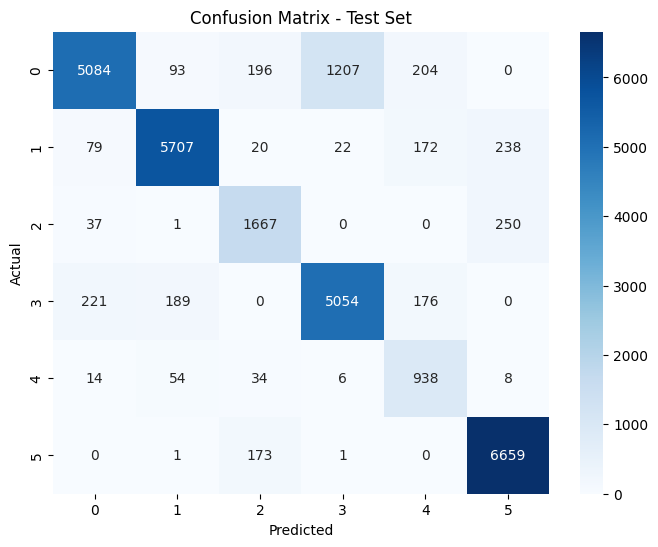

In [ ]:
# Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test_sample, y_test_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Test Set")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

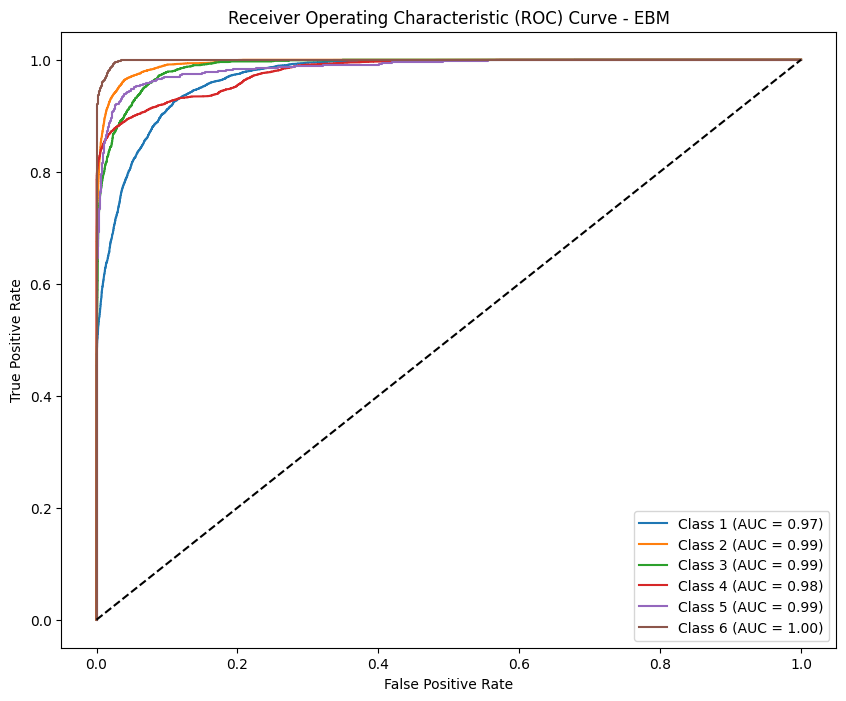

In [ ]:
from sklearn.metrics import roc_curve, auc  # Import auc function

# ROC-AUC Curve
# For multiclass ROC-AUC, we need to compute it for each class individually
fpr, tpr, roc_auc = {}, {}, {}

# One-hot encode the target variable
from sklearn.preprocessing import label_binarize
y_test_bin = label_binarize(y_test_sample, classes=[1, 2, 3, 4, 5, 6])
y_train_bin = label_binarize(y_train_sample, classes=[1, 2, 3, 4, 5, 6])

# Compute ROC curve and AUC for each class
for i in range(6):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], best_ebm_model.predict_proba(X_test_sample)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC-AUC curve
plt.figure(figsize=(10, 8))
for i in range(6):
    plt.plot(fpr[i], tpr[i], label=f'Class {i+1} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - EBM')
plt.legend(loc="lower right")
plt.show()


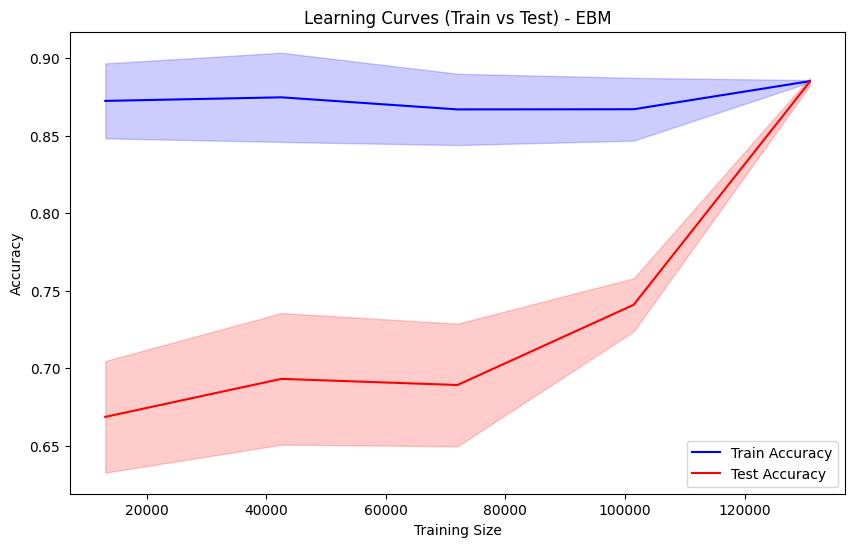

In [ ]:
from sklearn.model_selection import learning_curve  # Import learning_curve

# Learning Curves (Train vs Test)
train_sizes, train_scores, test_scores = learning_curve(best_ebm_model, X_train_sample, y_train_sample, cv=5, n_jobs=-1, scoring='accuracy')

# Plot Learning Curves
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores.mean(axis=1), label='Train Accuracy', color='b')
plt.plot(train_sizes, test_scores.mean(axis=1), label='Test Accuracy', color='r')
plt.fill_between(train_sizes, train_scores.mean(axis=1) - train_scores.std(axis=1), train_scores.mean(axis=1) + train_scores.std(axis=1), alpha=0.2, color='b')
plt.fill_between(train_sizes, test_scores.mean(axis=1) - test_scores.std(axis=1), test_scores.mean(axis=1) + test_scores.std(axis=1), alpha=0.2, color='r')

plt.title('Learning Curves (Train vs Test) - EBM')
plt.xlabel('Training Size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()


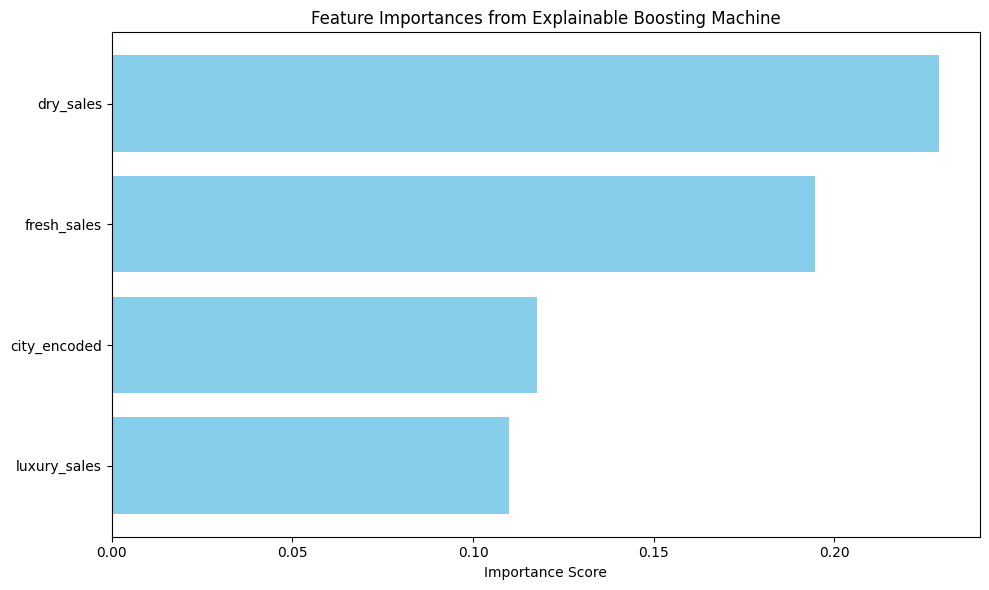

In [17]:
import matplotlib.pyplot as plt
import pandas as pd

# Get global explanation
global_explanation = best_ebm_model.explain_global()

# Extract names and importance scores
feature_names = global_explanation.data()['names']
feature_scores = global_explanation.data()['scores']

# Create a DataFrame for easy sorting and plotting
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_scores
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance Score')
plt.title('Feature Importances from Explainable Boosting Machine')
plt.gca().invert_yaxis()  # Highest at the top
plt.tight_layout()
plt.show()


# Random Forest (Train Accuracy: 1.0000, Test Accuracy: 0.9980)

In [37]:
from sklearn.ensemble import RandomForestClassifier
# Define Random Forest model
rf_model = RandomForestClassifier(random_state=42)


In [40]:
# Define parameter grid for RandomizedSearchCV
param_grid = {
    "n_estimators": [100, 200, 300],  # Number of trees
    "max_depth": [10, 15, 20],  # Max depth of trees
    "min_samples_split": [2, 5, 10],  # Minimum samples to split an internal node
    "min_samples_leaf": [1, 2, 4],  # Minimum samples at a leaf node
    "max_features": ['sqrt', 'log2'],  # Number of features to consider
    "bootstrap": [True, False]  # Whether to use bootstrap sampling
}

In [41]:
# Perform RandomizedSearchCV to find the best parameters
random_search = RandomizedSearchCV(rf_model, param_grid, cv=3, n_iter=10, scoring='accuracy', n_jobs=-1, random_state=42)
random_search.fit(X_train_sample, y_train_sample)

# Print the best parameters found by RandomizedSearchCV
print(f"\n✅ Best Parameters for Random Forest: {random_search.best_params_}")

# Get the best model
best_rf_model = random_search.best_estimator_


✅ Best Parameters for Random Forest: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 20, 'bootstrap': True}


In [42]:
# Use the best model to make predictions
y_train_pred = best_rf_model.predict(X_train_sample)
y_test_pred = best_rf_model.predict(X_test_sample)

# Print accuracy and classification report
train_acc = accuracy_score(y_train_sample, y_train_pred)
test_acc = accuracy_score(y_test_sample, y_test_pred)

print(f"🔹 Random Forest Accuracy:")
print(f"   Train Accuracy: {train_acc:.4f}")
print(f"   Test Accuracy: {test_acc:.4f}")

# Print classification report for the test set
print("\n🔹 Classification Report for Random Forest:")
print(classification_report(y_test_sample, y_test_pred))

🔹 Random Forest Accuracy:
   Train Accuracy: 1.0000
   Test Accuracy: 0.9980

🔹 Classification Report for Random Forest:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00      6784
           2       1.00      1.00      1.00      6238
           3       0.99      1.00      1.00      1955
           4       1.00      1.00      1.00      5640
           5       0.99      0.99      0.99      1054
           6       1.00      1.00      1.00      6834

    accuracy                           1.00     28505
   macro avg       1.00      1.00      1.00     28505
weighted avg       1.00      1.00      1.00     28505



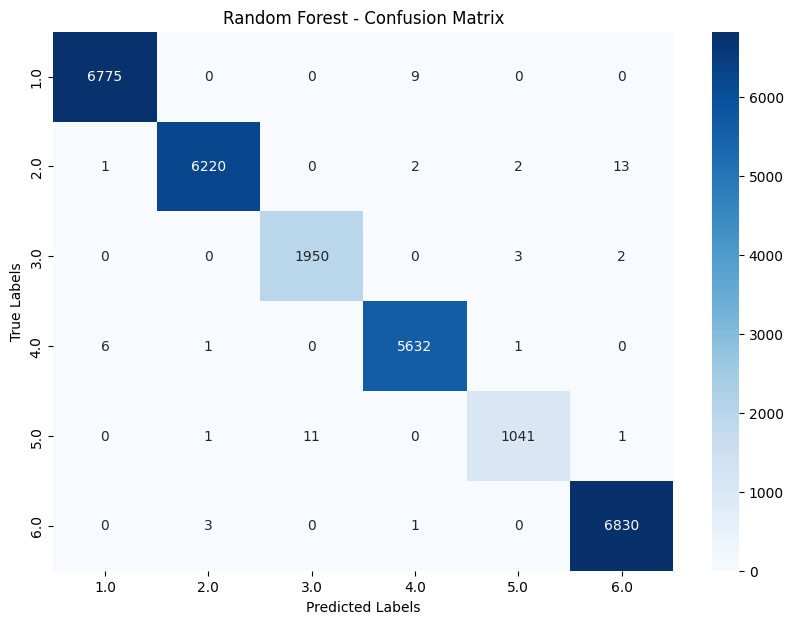

In [43]:
# Plot Confusion Matrix for Test Set
cm = confusion_matrix(y_test_sample, y_test_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Random Forest - Confusion Matrix")
plt.show()



🔹 ROC-AUC Score for Random Forest: 0.9999


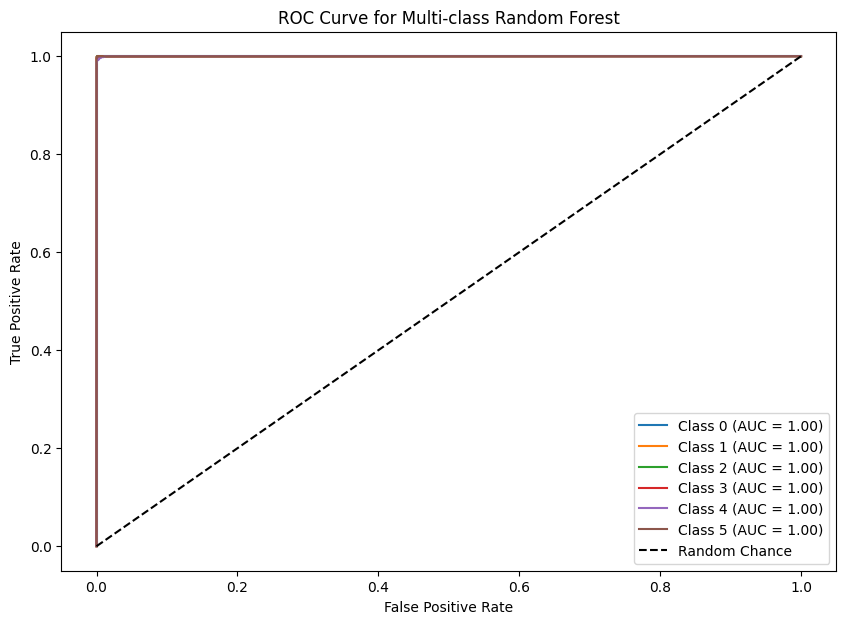

In [44]:
# Evaluate Model Performance using ROC-AUC score
# ROC-AUC for multi-class classification
roc_auc = roc_auc_score(y_test_sample, best_rf_model.predict_proba(X_test_sample), multi_class='ovr')
print(f"\n🔹 ROC-AUC Score for Random Forest: {roc_auc:.4f}")

# --- ROC Curve ---
# Binarize the labels for multi-class ROC curve
y_test_bin = label_binarize(y_test_sample, classes=np.unique(y_test_sample))

# Compute ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc_class = {}

for i in range(len(np.unique(y_test_sample))):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], best_rf_model.predict_proba(X_test_sample)[:, i])
    roc_auc_class[i] = roc_auc_score(y_test_bin[:, i], best_rf_model.predict_proba(X_test_sample)[:, i])

# Plot ROC curve for each class
plt.figure(figsize=(10, 7))
for i in range(len(np.unique(y_test_sample))):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc_class[i]:.2f})')

# Plot diagonal line (chance level)
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-class Random Forest')
plt.legend(loc='best')
plt.show()

<ipython-input-45-67fee030acda>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[indices], y=features[indices], palette='viridis')


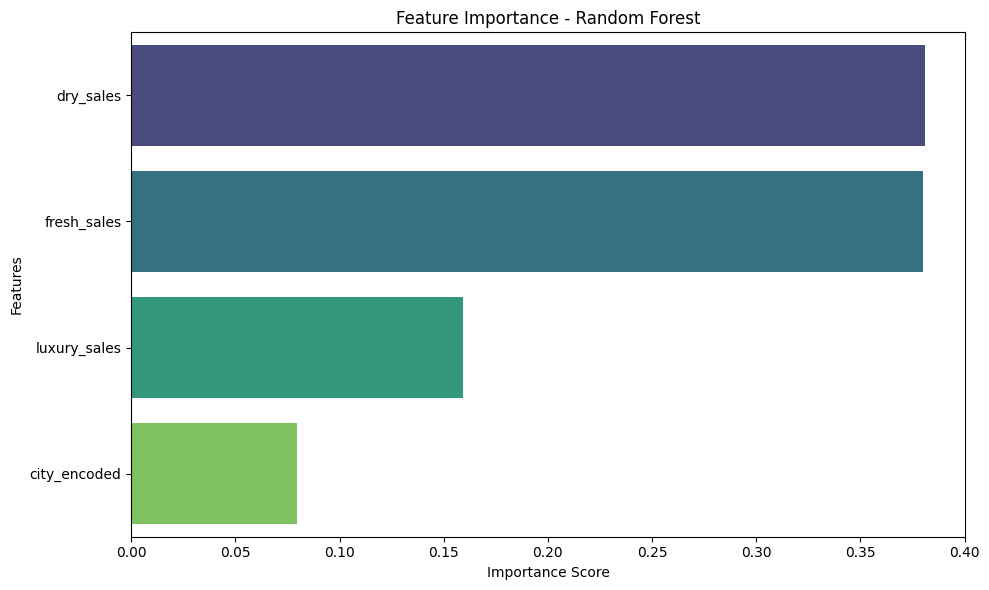

In [45]:
# Get feature importances
importances = best_rf_model.feature_importances_
features = X_train_sample.columns
indices = np.argsort(importances)[::-1]

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=importances[indices], y=features[indices], palette='viridis')
plt.title('Feature Importance - Random Forest')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

# XGBoost (Train Accuracy: 1.0000, Test Accuracy: 0.9995)

In [ ]:
# Adjust class labels to start from 0
y_adjusted = y - 1  # Shift labels from [1, 2, 3, 4, 5, 6] → [0, 1, 2, 3, 4, 5]

# Split the adjusted target
X_train_sample, X_test_sample, y_train_sample, y_test_sample = train_test_split(
    X, y_adjusted, test_size=0.2, random_state=42)


In [ ]:
# Import XGBoost
from xgboost import XGBClassifier

# Define XGBoost model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

In [ ]:
# Define hyperparameter grid for XGBoost
param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [3, 6, 9],
    "learning_rate": [0.01, 0.1, 0.2],
    "subsample": [0.7, 0.8, 1.0]
}

In [ ]:
# Perform RandomizedSearchCV for XGBoost
print(f"\n🔹 Training XGBoost with Randomized Search...\n")
random_search = RandomizedSearchCV(xgb_model, param_grid, cv=2, scoring='accuracy', n_jobs=-1, n_iter=10, random_state=42)
random_search.fit(X_train_sample, y_train_sample)
best_model = random_search.best_estimator_

print(f"✅ Best Parameters for XGBoost: {random_search.best_params_}\n")


🔹 Training XGBoost with Randomized Search...



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[17:27:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.




✅ Best Parameters for XGBoost: {'subsample': 0.8, 'n_estimators': 300, 'max_depth': 6, 'learning_rate': 0.2}



In [ ]:
# Get predictions and restore original labels
y_train_pred = best_model.predict(X_train_sample)   # Shift labels back: [0,1,2,3,4,5] → [1,2,3,4,5,6]
y_test_pred = best_model.predict(X_test_sample)

In [ ]:
# Train and test accuracy
train_acc_xgb = accuracy_score(y_train_sample, y_train_pred)
test_acc_xgb = accuracy_score(y_test_sample, y_test_pred)

print(f"🔹 XGBoost Accuracy:")
print(f"   Train Accuracy: {train_acc_xgb:.4f}")
print(f"   Test Accuracy: {test_acc_xgb:.4f}")

if train_acc_xgb - test_acc_xgb > 0.1:
    print(f"⚠️ Warning: XGBoost may be overfitting!\n")

print(f"\n🔹 Classification Report for XGBoost:\n")
print(classification_report(y_test_sample, y_test_pred))

🔹 XGBoost Accuracy:
   Train Accuracy: 1.0000
   Test Accuracy: 0.9995

🔹 Classification Report for XGBoost:

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      6784
         1.0       1.00      1.00      1.00      6238
         2.0       1.00      1.00      1.00      1955
         3.0       1.00      1.00      1.00      5640
         4.0       1.00      0.99      1.00      1054
         5.0       1.00      1.00      1.00      6834

    accuracy                           1.00     28505
   macro avg       1.00      1.00      1.00     28505
weighted avg       1.00      1.00      1.00     28505



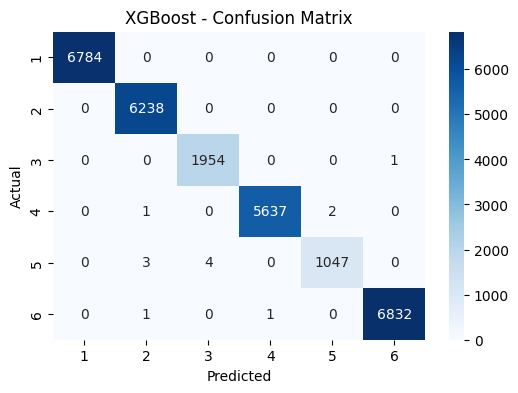

In [ ]:
# Confusion Matrix
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test_sample, y_test_pred), annot=True, fmt="d", cmap="Blues", xticklabels=range(1,7), yticklabels=range(1,7))
plt.title(f"XGBoost - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


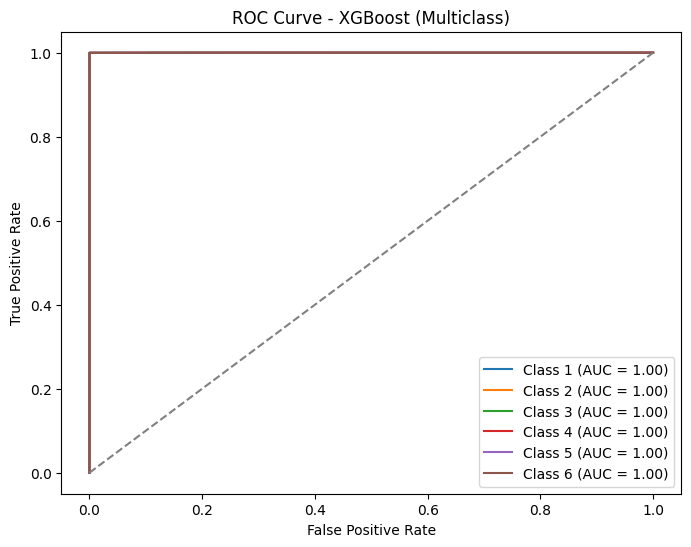

In [ ]:
from sklearn.preprocessing import label_binarize

# Binarize labels with adjusted range [0,1,2,3,4,5]
y_test_binarized = label_binarize(y_test_sample, classes=[0, 1, 2, 3, 4, 5])

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(y_test_binarized.shape[1]):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_test_pred_proba[:, i])
    auc = roc_auc_score(y_test_binarized[:, i], y_test_pred_proba[:, i])
    plt.plot(fpr, tpr, label=f'Class {i+1} (AUC = {auc:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('ROC Curve - XGBoost (Multiclass)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()


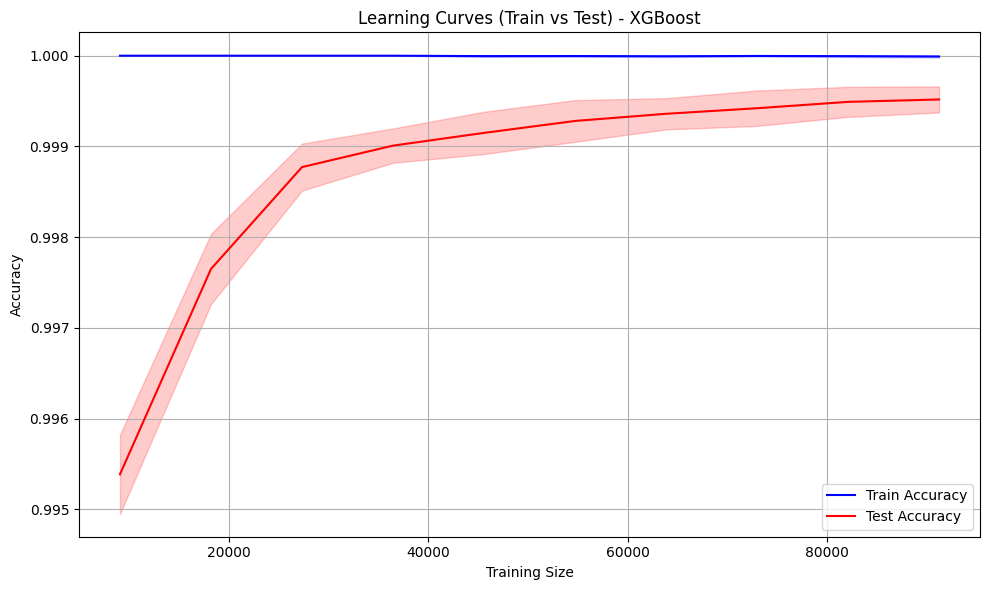

In [ ]:
from sklearn.model_selection import learning_curve  # Import if not already

# Learning Curves (Train vs Test) for XGBoost
train_sizes, train_scores, test_scores = learning_curve(
    best_model, X_train_sample, y_train_sample,
    cv=5, n_jobs=-1, scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10),
    shuffle=True, random_state=42
)

# Plot Learning Curves
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores.mean(axis=1), label='Train Accuracy', color='b')
plt.plot(train_sizes, test_scores.mean(axis=1), label='Test Accuracy', color='r')
plt.fill_between(train_sizes,
                 train_scores.mean(axis=1) - train_scores.std(axis=1),
                 train_scores.mean(axis=1) + train_scores.std(axis=1),
                 alpha=0.2, color='b')
plt.fill_between(train_sizes,
                 test_scores.mean(axis=1) - test_scores.std(axis=1),
                 test_scores.mean(axis=1) + test_scores.std(axis=1),
                 alpha=0.2, color='r')

plt.title('Learning Curves (Train vs Test) - XGBoost')
plt.xlabel('Training Size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()

<ipython-input-46-8d13a924f913>:8: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




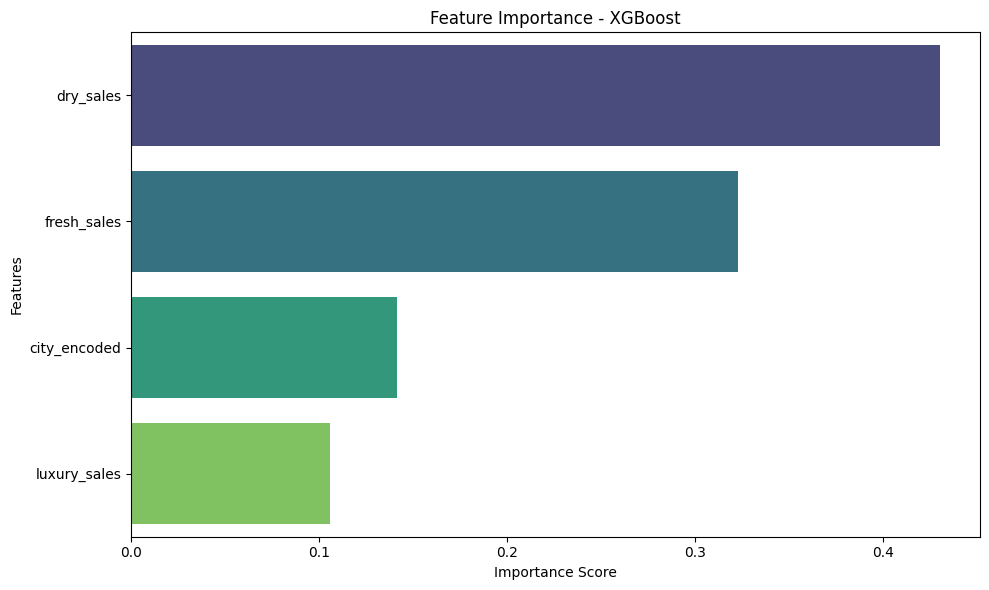

In [ ]:
# Get feature importances from the best XGBoost model
importances = best_model.feature_importances_
features = X_train_sample.columns
indices = np.argsort(importances)[::-1]

# Plot Feature Importances
plt.figure(figsize=(10, 6))
sns.barplot(x=importances[indices], y=features[indices], palette='viridis')
plt.title('Feature Importance - XGBoost')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()


# LightGBM (Train Accuracy: 1.0000, Test Accuracy: 0.9994)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize
from lightgbm import LGBMClassifier

In [ ]:
# Define LightGBM model and hyperparameter grid
lgbm_model = LGBMClassifier()
param_grid = {
    "n_estimators": [100, 200, 300],
    "num_leaves": [31, 50, 100],
    "learning_rate": [0.01, 0.1, 0.2]}

In [ ]:
# Perform RandomizedSearchCV
print(f"\n🔹 Training LightGBM...\n")
random_search = RandomizedSearchCV(lgbm_model, param_grid, cv=2, scoring='accuracy', n_jobs=-1, n_iter=10, random_state=42)
random_search.fit(X_train_sample, y_train_sample)
best_model = random_search.best_estimator_

print(f"✅ Best Parameters for LightGBM: {random_search.best_params_}\n")



🔹 Training LightGBM...

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006563 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 786
[LightGBM] [Info] Number of data points in the train set: 163620, number of used features: 4
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

In [ ]:
# Predictions
y_train_pred = best_model.predict(X_train_sample)
y_test_pred = best_model.predict(X_test_sample)


In [ ]:
# Train and test accuracy
train_acc = accuracy_score(y_train_sample, y_train_pred)
test_acc = accuracy_score(y_test_sample, y_test_pred)

print(f"🔹 LightGBM Accuracy:")
print(f"   Train Accuracy: {train_acc:.4f}")
print(f"   Test Accuracy: {test_acc:.4f}")

if train_acc - test_acc > 0.1:
    print(f"⚠️ Warning: LightGBM may still be overfitting! Try adjusting `num_leaves`, `min_child_samples`, or `reg_alpha` and `reg_lambda`.\n")

print(f"\n🔹 Classification Report for LightGBM:\n")
print(classification_report(y_test_sample, y_test_pred))

🔹 LightGBM Accuracy:
   Train Accuracy: 1.0000
   Test Accuracy: 0.9994

🔹 Classification Report for LightGBM:

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      6784
           2       1.00      1.00      1.00      6238
           3       1.00      1.00      1.00      1955
           4       1.00      1.00      1.00      5640
           5       1.00      1.00      1.00      1054
           6       1.00      1.00      1.00      6834

    accuracy                           1.00     28505
   macro avg       1.00      1.00      1.00     28505
weighted avg       1.00      1.00      1.00     28505



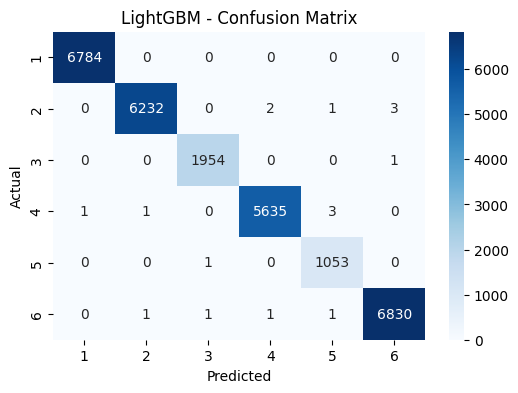

In [ ]:
# Confusion Matrix
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test_sample, y_test_pred), annot=True, fmt="d", cmap="Blues", xticklabels=range(1,7), yticklabels=range(1,7))
plt.title(f"LightGBM - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

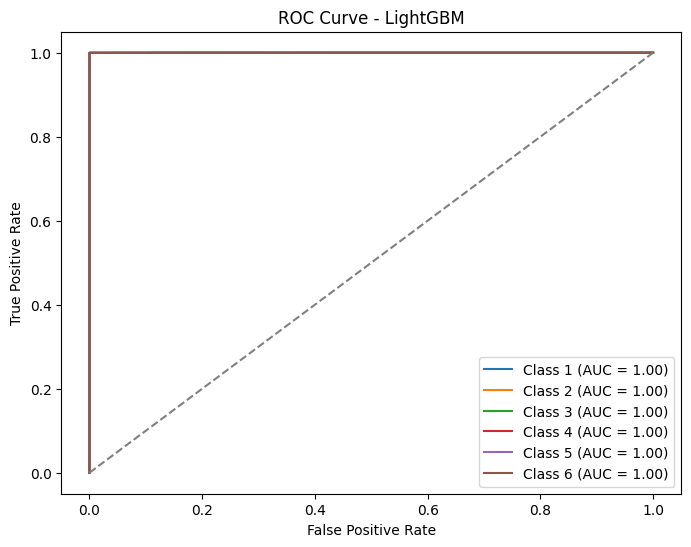

In [ ]:
# Plot ROC curve for LightGBM (Multiclass)
y_test_binarized = label_binarize(y_test_sample, classes=np.unique(y_test_sample))
y_test_pred_proba = best_model.predict_proba(X_test_sample)

plt.figure(figsize=(8, 6))

for i in range(y_test_binarized.shape[1]):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_test_pred_proba[:, i])
    auc = roc_auc_score(y_test_binarized[:, i], y_test_pred_proba[:, i])
    plt.plot(fpr, tpr, label=f'Class {i+1} (AUC = {auc:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('ROC Curve - LightGBM')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

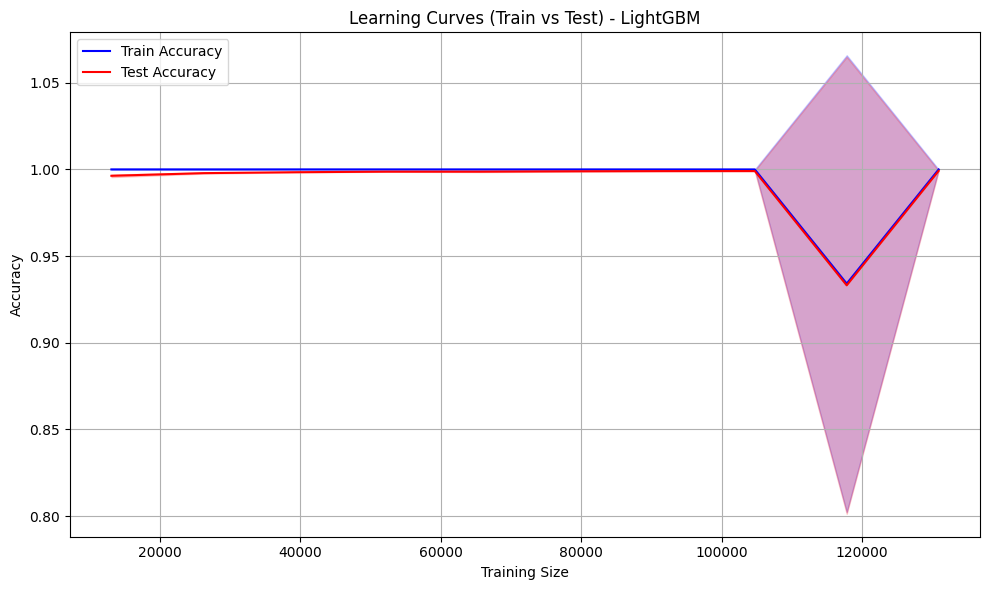

In [ ]:
from sklearn.model_selection import learning_curve  # Import if not already

# Learning Curves (Train vs Test) for LightGBM
train_sizes, train_scores, test_scores = learning_curve(
    best_model, X_train_sample, y_train_sample,
    cv=5, n_jobs=-1, scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10),
    shuffle=True, random_state=42
)

# Plot Learning Curves
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores.mean(axis=1), label='Train Accuracy', color='b')
plt.plot(train_sizes, test_scores.mean(axis=1), label='Test Accuracy', color='r')
plt.fill_between(train_sizes,
                 train_scores.mean(axis=1) - train_scores.std(axis=1),
                 train_scores.mean(axis=1) + train_scores.std(axis=1),
                 alpha=0.2, color='b')
plt.fill_between(train_sizes,
                 test_scores.mean(axis=1) - test_scores.std(axis=1),
                 test_scores.mean(axis=1) + test_scores.std(axis=1),
                 alpha=0.2, color='r')

plt.title('Learning Curves (Train vs Test) - LightGBM')
plt.xlabel('Training Size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()

<ipython-input-36-0cd711e104ed>:8: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




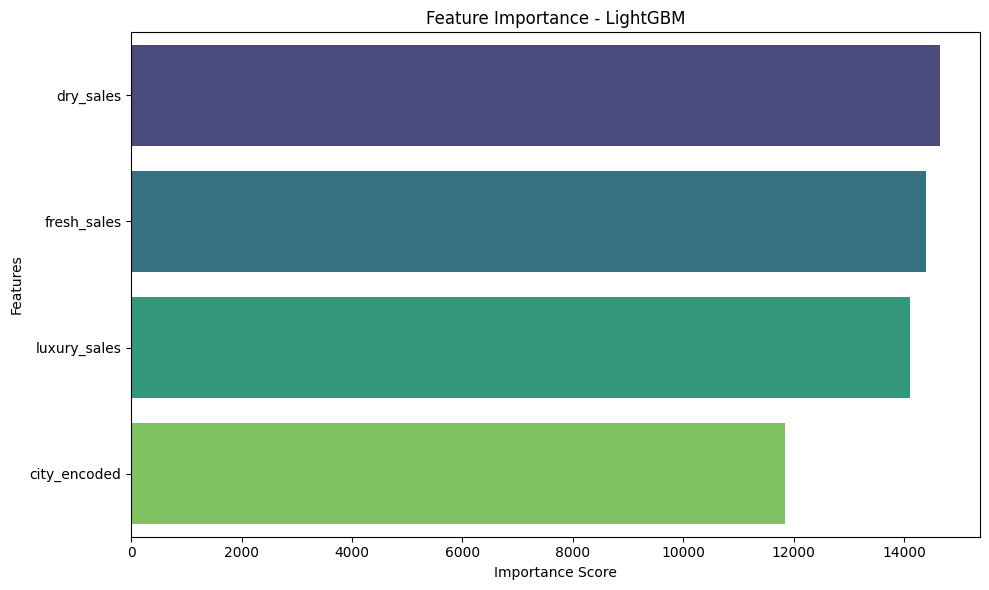

In [ ]:
# Get feature importances
importances = best_model.feature_importances_
features = X_train_sample.columns
indices = np.argsort(importances)[::-1]

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=importances[indices], y=features[indices], palette='viridis')
plt.title('Feature Importance - LightGBM')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

# KNN (Train Accuracy: 1.0000, Test Accuracy: 0.9971)

In [20]:
from sklearn.neighbors import KNeighborsClassifier
# Define KNN model
knn_model = KNeighborsClassifier()

In [22]:
knn_param_grid = {
    "n_neighbors": [7, 9, 11, 13, 15],
    "weights": ["uniform", "distance"],
    "metric": ["euclidean", "manhattan"]
}

In [23]:
# Perform RandomizedSearchCV with larger grid and cross-validation
print(f"\n🔹 Training KNN...\n")
knn_random_search = RandomizedSearchCV(knn_model, knn_param_grid, cv=5, scoring='accuracy', n_jobs=-1, n_iter=10, random_state=42)
knn_random_search.fit(X_train_sample, y_train_sample)

# Get best model and parameters
best_knn_model = knn_random_search.best_estimator_

print(f"✅ Best Parameters for KNN: {knn_random_search.best_params_}\n")


🔹 Training KNN...

✅ Best Parameters for KNN: {'weights': 'distance', 'n_neighbors': 7, 'metric': 'manhattan'}



In [24]:
# Evaluate on training and test sets
y_train_pred = best_knn_model.predict(X_train_sample)
y_test_pred = best_knn_model.predict(X_test_sample)

# Accuracy on training and test data
train_acc = accuracy_score(y_train_sample, y_train_pred)
test_acc = accuracy_score(y_test_sample, y_test_pred)

# Print accuracy and classification report
print(f"🔹 KNN Accuracy:")
print(f"   Train Accuracy: {train_acc:.4f}")
print(f"   Test Accuracy: {test_acc:.4f}")

# Classification Report for KNN
print("\n🔹 Classification Report for KNN:")
print(classification_report(y_test_sample, y_test_pred))

🔹 KNN Accuracy:
   Train Accuracy: 1.0000
   Test Accuracy: 0.9971

🔹 Classification Report for KNN:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00      6784
           2       1.00      1.00      1.00      6238
           3       0.99      1.00      0.99      1955
           4       1.00      1.00      1.00      5640
           5       0.99      0.99      0.99      1054
           6       1.00      1.00      1.00      6834

    accuracy                           1.00     28505
   macro avg       0.99      1.00      1.00     28505
weighted avg       1.00      1.00      1.00     28505



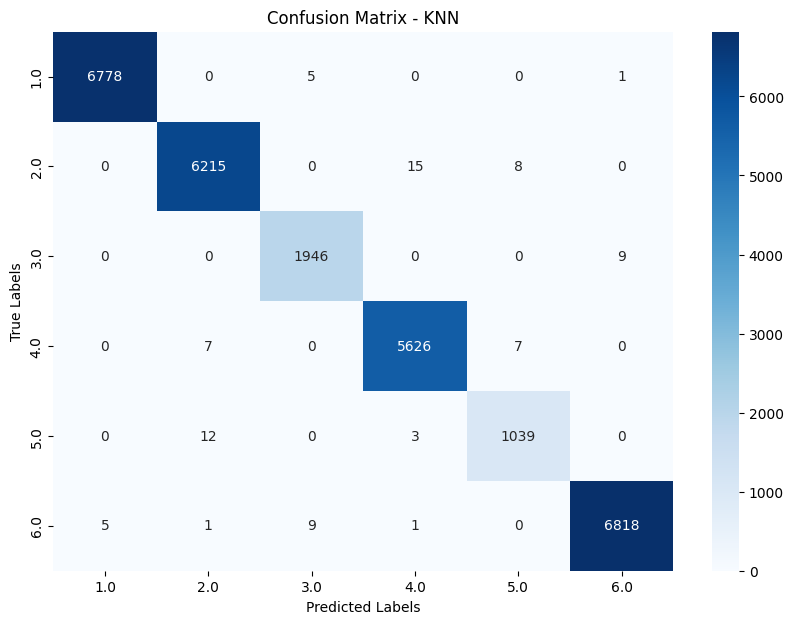

In [25]:
# Plot confusion matrix (optional for better understanding of misclassifications)
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test_sample, y_test_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix - KNN")
plt.show()

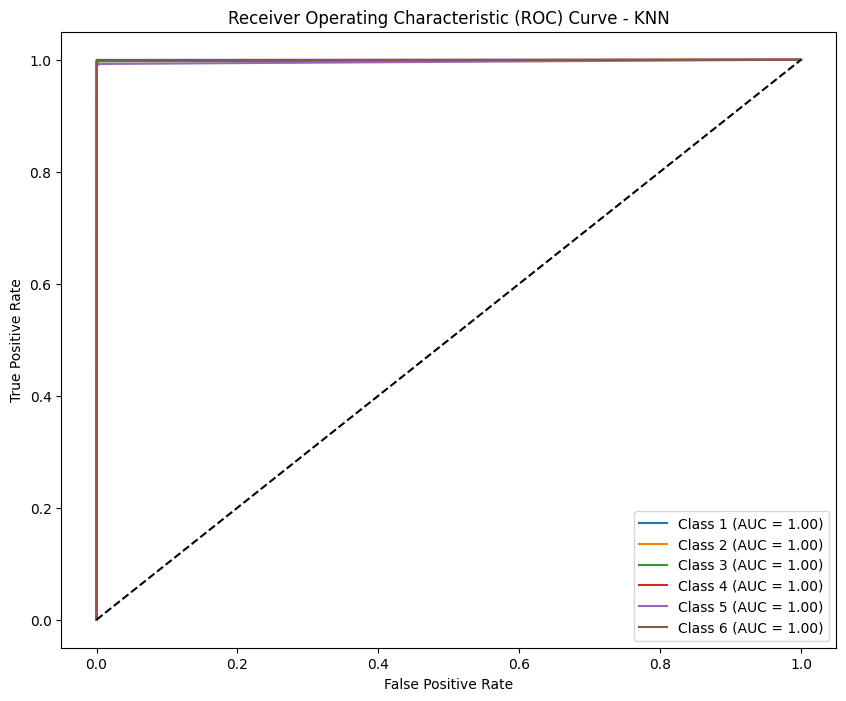

In [26]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# One-hot encode test labels
y_test_bin = label_binarize(y_test_sample, classes=[1, 2, 3, 4, 5, 6])

# Get predicted probabilities
y_proba_knn = best_knn_model.predict_proba(X_test_sample)

# Compute ROC curve and AUC for each class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(6):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_proba_knn[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC-AUC curve
plt.figure(figsize=(10, 8))
for i in range(6):
    plt.plot(fpr[i], tpr[i], label=f'Class {i+1} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - KNN')
plt.legend(loc="lower right")
plt.show()


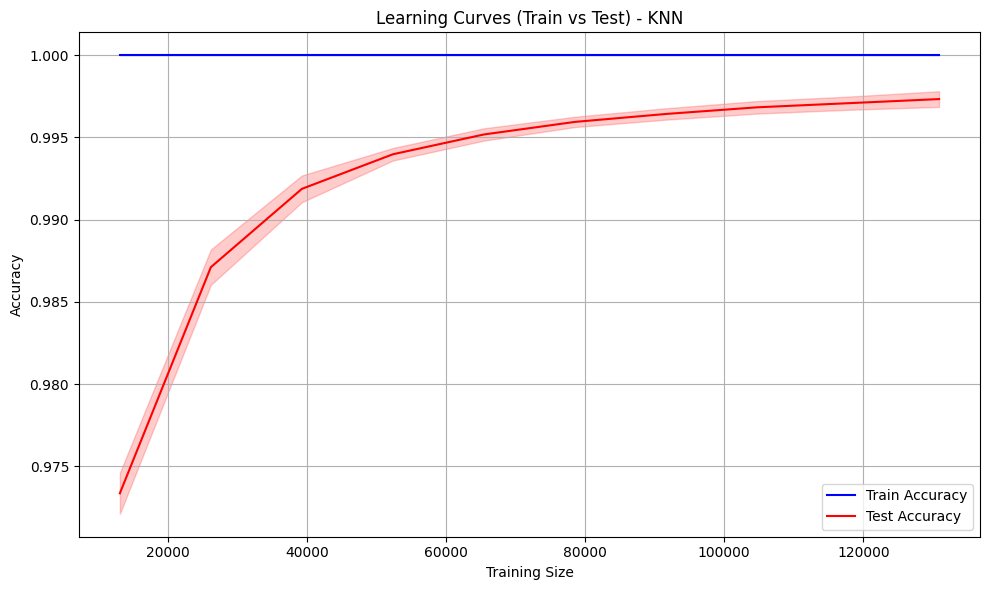

In [27]:
from sklearn.model_selection import learning_curve

# Learning Curve for KNN
train_sizes, train_scores, test_scores = learning_curve(
    best_knn_model, X_train_sample, y_train_sample,
    cv=5, n_jobs=-1, scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10),
    shuffle=True, random_state=42
)

# Plot Learning Curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores.mean(axis=1), label='Train Accuracy', color='b')
plt.plot(train_sizes, test_scores.mean(axis=1), label='Test Accuracy', color='r')
plt.fill_between(train_sizes,
                 train_scores.mean(axis=1) - train_scores.std(axis=1),
                 train_scores.mean(axis=1) + train_scores.std(axis=1),
                 alpha=0.2, color='b')
plt.fill_between(train_sizes,
                 test_scores.mean(axis=1) - test_scores.std(axis=1),
                 test_scores.mean(axis=1) + test_scores.std(axis=1),
                 alpha=0.2, color='r')

plt.title('Learning Curves (Train vs Test) - KNN')
plt.xlabel('Training Size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()


# Multinomial Logistic Regression Model (Train Accuracy: 0.7078, Test Accuracy: 0.7148

In [28]:
from sklearn.linear_model import LogisticRegression
# Define Logistic Regression model
log_reg_model = LogisticRegression(solver='lbfgs', multi_class='multinomial', random_state=42)

In [29]:
# Adjusted parameter grid with higher max_iter
param_grid = {
    'C': [0.1, 1, 10],  # Try a range of C values
    'max_iter': [1000, 2000, 3000]  # Increase iterations further
}

In [30]:
# Perform RandomizedSearchCV for Logistic Regression
print(f"\n🔹 Training Logistic Regression...\n")
random_search = RandomizedSearchCV(log_reg_model, param_grid, n_iter=5, cv=3, scoring='accuracy', n_jobs=-1, random_state=42)

# Fit the model
random_search.fit(X_train_sample, y_train_sample)

# Get the best model from RandomizedSearchCV
best_model = random_search.best_estimator_

# Print best parameters found
print(f"✅ Best Parameters for Logistic Regression: {random_search.best_params_}\n")


🔹 Training Logistic Regression...



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


✅ Best Parameters for Logistic Regression: {'max_iter': 3000, 'C': 10}



In [31]:
# 🔹 Predictions and Accuracy Evaluation
# Train and test predictions
y_train_pred = best_model.predict(X_train_sample)
y_test_pred = best_model.predict(X_test_sample)

# Evaluate train and test accuracy
train_acc = accuracy_score(y_train_sample, y_train_pred)
test_acc = accuracy_score(y_test_sample, y_test_pred)

print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

Train Accuracy: 0.7078
Test Accuracy: 0.7148


Classification Report:
              precision    recall  f1-score   support

           1       0.61      0.52      0.56      6784
           2       0.94      0.75      0.83      6238
           3       0.56      0.74      0.64      1955
           4       0.59      0.69      0.64      5640
           5       0.35      0.66      0.46      1054
           6       0.93      0.89      0.91      6834

    accuracy                           0.71     28505
   macro avg       0.66      0.71      0.67     28505
weighted avg       0.74      0.71      0.72     28505



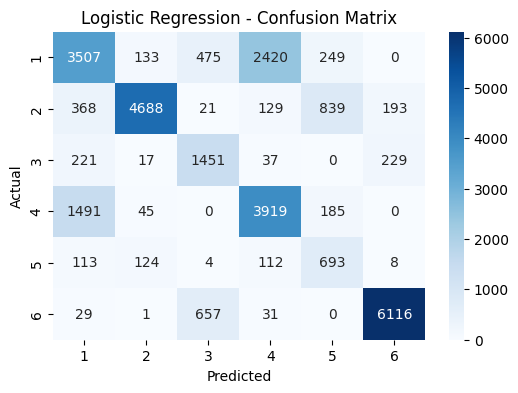

In [32]:
# 🔹 Classification Report
print(f"Classification Report:\n{classification_report(y_test_sample, y_test_pred)}")

# 🔹 Confusion Matrix
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test_sample, y_test_pred), annot=True, fmt="d", cmap="Blues", xticklabels=range(1, 7), yticklabels=range(1, 7))
plt.title("Logistic Regression - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

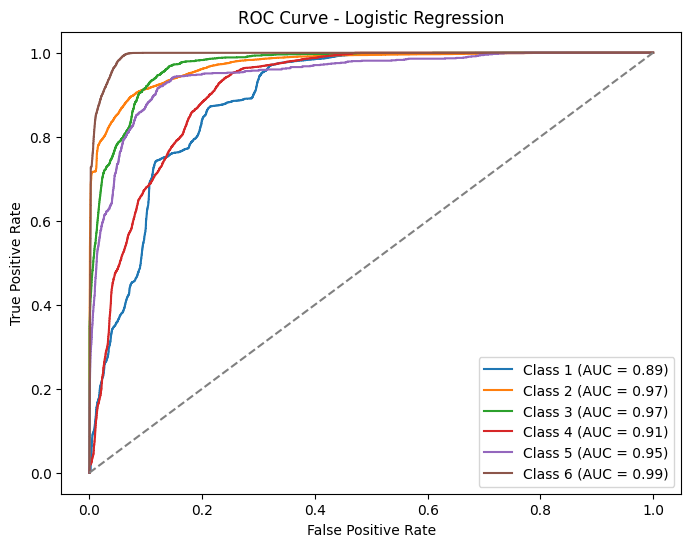

In [33]:
# 🔹 ROC Curve (Multiclass) - All in one graph

# Binarize the labels for multiclass ROC
y_test_binarized = label_binarize(y_test_sample, classes=[1, 2, 3, 4, 5, 6])  # Adjust range if necessary

# Get predicted probabilities for all classes
y_test_pred_proba = best_model.predict_proba(X_test_sample)

# Plot ROC curve for all classes on the same graph
plt.figure(figsize=(8, 6))

# Compute ROC curve and AUC for each class
for i in range(y_test_binarized.shape[1]):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_test_pred_proba[:, i])
    auc = roc_auc_score(y_test_binarized[:, i], y_test_pred_proba[:, i])
    plt.plot(fpr, tpr, label=f'Class {i+1} (AUC = {auc:.2f})')

# Plot diagonal line (random model)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

# Add titles and labels
plt.title('ROC Curve - Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

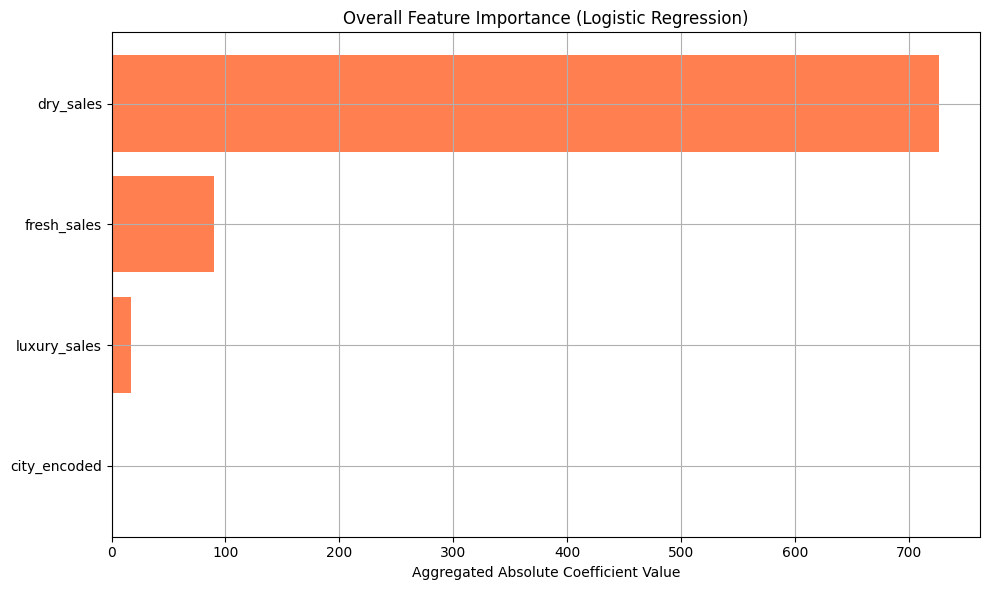

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Feature names
feature_names = X_train_sample.columns if hasattr(X_train_sample, 'columns') else [f'Feature {i}' for i in range(X_train_sample.shape[1])]

# Coefficients from the trained model
coefs = best_model.coef_

# Aggregate: sum absolute values of coefficients across all classes
importance_scores = np.sum(np.abs(coefs), axis=0)

# Create a DataFrame to sort and plot
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance_scores
}).sort_values(by='Importance', ascending=False)

# Select top 15 features
top_n = 15
top_features_df = importance_df.head(top_n)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(top_features_df['Feature'], top_features_df['Importance'], color='coral')
plt.xlabel('Aggregated Absolute Coefficient Value')
plt.title('Overall Feature Importance (Logistic Regression)')
plt.gca().invert_yaxis()  # Show top feature at the top
plt.grid(True)
plt.tight_layout()
plt.show()


# Saving Selected Model

In [19]:
import pickle

# Save the model using pickle
model_filename = 'final_model_ebm.pkl'
with open(model_filename, 'wb') as f:
    pickle.dump(best_ebm_model, f)
    print(f"🔹 Model saved to {model_filename}")

🔹 Model saved to final_model_ebm.pkl
